In [93]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.optim as optim

import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

from sklearn.metrics import roc_auc_score, roc_curve
import numpy as np

from PIL import Image
import cv2
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "5"

### Common CONSTANT

In [2]:
N_CLASSES = 14
CLASS_NAMES = [ 'Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass', 'Nodule', 'Pneumonia',
                'Pneumothorax', 'Consolidation', 'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia']
WIDTH = 224
HEIGHT = 224
CHANNELS = 3
BATCHSIZE = 16 #64*2
IMAGENET_RGB_MEAN = [0.485, 0.456, 0.406]
IMAGENET_RGB_SD = [0.229, 0.224, 0.225]
DATA_DIR = '/home/dattran/data/xray/'
PERCENTAGE = 0.01 # percentage of data use for quick run
MODEL_NAME = 'model.pth.tar'

In [3]:
# check the length of NIH training validation and testing set
print('train val size')
!cat train_val_list.csv | wc -l
print('test size')
!cat test_list.csv | wc -l

train val size
76193
test size
19049


### Utitlity for traininng and testing

In [4]:
class XrayDataset(Dataset):
    '''
    Get image for train, validate and test base on NIH split
    '''
    
    def __init__(self, 
                 image_list_file='test_list.csv', 
                 transform=None, 
                 percentage=0.01):
        data = pd.read_csv(image_list_file, sep=' ', header=None)
        self.images = data.iloc[:, 0].as_matrix()
        self.labels = data.iloc[:, 1:].as_matrix()
        self.transform = transform
        self.percentage = percentage
    
    def __getitem__(self, index):
        image_file = DATA_DIR + self.images[index]
        image = Image.open(image_file).convert('RGB')
#         image = imread(image_file)
        label = self.labels[index]
        if self.transform:
            image = self.transform(image)
        return image, torch.FloatTensor(label)
    
    def __len__(self):
        return int(self.images.shape[0] * self.percentage)

In [5]:
class DenseNet121(nn.Module):
    
    def __init__(self, out_size):
        super(DenseNet121, self).__init__()
        self.densenet121 = torchvision.models.densenet121(pretrained=True)
        num_ftrs = self.densenet121.classifier.in_features
        self.densenet121.classifier = nn.Sequential(
            nn.Linear(num_ftrs, out_size),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.densenet121(x)
        return x


In [6]:
def agumented_dataloader(image_list_file='train_val_list.csv', percentage=PERCENTAGE):
    # TODO: Implement kFold for train test split
    normalize = transforms.Normalize(IMAGENET_RGB_MEAN, IMAGENET_RGB_SD)
    transform = transforms.Compose([
        transforms.Resize(264),
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop(size=WIDTH),
        transforms.ColorJitter(0.15, 0.15),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        normalize
    ])
    dataset = XrayDataset(image_list_file, transform, percentage)
    return DataLoader(dataset=dataset, batch_size=BATCHSIZE,
                      shuffle=True, num_workers=2, pin_memory=False)

In [7]:
def non_agumented_dataloader(image_list_file='test_list.csv', percentage=PERCENTAGE):
    normallize = transforms.Normalize(IMAGENET_RGB_MEAN, IMAGENET_RGB_SD)
    transform = transforms.Compose([
        transforms.Resize(WIDTH),
        transforms.ToTensor(),
        normallize
    ])
    dataset = XrayDataset(image_list_file, transform, percentage)
    return DataLoader(dataset=dataset, batch_size=4*BATCHSIZE,
                      shuffle=False, num_workers=4, pin_memory=False)

In [8]:
def train_epoch(model, dataloader, optimizer, criterion):
    model.train()
    for data, target in dataloader:
        data = Variable(torch.FloatTensor(data).cuda())
        target = Variable(torch.FloatTensor(target).cuda())
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

In [9]:
def valid_epoch(model, dataloader, criterion):
    model.eval()
    losses = []
    for data, target in dataloader:
        data = Variable(torch.FloatTensor(data).cuda(), volatile=True)
        target = Variable(torch.FloatTensor(target).cuda(), volatile=True)
         
        output = model(data)
        loss = criterion(output, target)
        loss_val.append(loss.data[0])
    return np.mean(losses)
        

In [10]:
def test(model, dataloader):
    targets = torch.FloatTensor()
    targets = targets.cuda()
    preds = torch.FloatTensor()
    preds = preds.cuda()
    
    for data, target in dataloader:
        target = target.cuda()
        data = Variable(data.cuda(), volatile=True)
        pred = model(data)
        targets = torch.cat((targets, target), 0)
        preds = torch.cat((preds, pred.data), 0)
    aurocs = compute_aucs(targets, preds)
    aurocs_avg = np.array(aurocs).mean()
    print('The average AUROC is {0:.3f}'.format(aurocs_avg))
    for i in range(N_CLASSES):
        print('The AUROC of {} is {}'.format(CLASS_NAMES[i], aurocs[i]))

In [11]:
def compute_aucs(targets, preds):
    aurocs = []
    targets = targets.cpu().numpy()
    preds = preds.cpu().numpy()
    for i in range(N_CLASSES):
        aurocs.append(roc_auc_score(targets[:, i], preds[:, i]))
    return aurocs

In [12]:
net = DenseNet121(N_CLASSES).cuda()
net = torch.nn.DataParallel(net, device_ids=[0]).cuda()
optimizer = optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999))
criterion = nn.BCELoss()
scheduler = ReduceLROnPlateau(optimizer, factor=0.1, patience=5, mode='min')

### Training

### Testing
Should testing on strong label images

In [103]:
test_loader = non_agumented_dataloader(image_list_file='chexnet_test_list.txt', percentage=1)
checkpoint = torch.load(MODEL_NAME)
net.load_state_dict(checkpoint['state_dict'])

In [104]:
test(net, test_loader)

The average AUROC is 0.799
The AUROC of Atelectasis is 0.7967774768714384
The AUROC of Cardiomegaly is 0.855220635981808
The AUROC of Effusion is 0.8483011170979037
The AUROC of Infiltration is 0.6696520177374885
The AUROC of Mass is 0.808861264083471
The AUROC of Nodule is 0.7399943832651124
The AUROC of Pneumonia is 0.7479230839991344
The AUROC of Pneumothorax is 0.7942862676788328
The AUROC of Consolidation is 0.7595970657046051
The AUROC of Edema is 0.8655230881896933
The AUROC of Emphysema is 0.8764313153243443
The AUROC of Fibrosis is 0.7921805469090086
The AUROC of Pleural_Thickening is 0.7467065183254719
The AUROC of Hernia is 0.8785130505241263


### CAM

In [44]:
class FeatureExtractor(DenseNet121):
    
    def __init__(self):
        super(FeatureExtractor, self).__init__(14) 
    
    def extract(self):
        self.extractor = nn.Sequential(
            *list(self.densenet121.features.children())[:-1]
        )
        print('extractor')
        
    def forward(self, x):
        return self.extractor.forward(x)



extractor = FeatureExtractor().cuda()
extractor_paralle = torch.nn.DataParallel(extractor, device_ids=[0]).cuda()
extractor_paralle.load_state_dict(checkpoint['state_dict'])
extractor.extract()


extractor


In [107]:
def cam_data(image_file_list, n=10):
    '''
    Get n random image from image_file_list for CAM visualization
    '''
    normallize = transforms.Normalize(IMAGENET_RGB_MEAN, IMAGENET_RGB_SD)
    transform = transforms.Compose([
        transforms.Resize(WIDTH),
        transforms.ToTensor(),
        normallize
    ])
    dataset = XrayDataset(image_file_list, 
                          percentage=1)
    idx = np.random.randint(0, len(dataset))
    images = []
    labels = []
    inputs = []
    for i in idx:
        image, label = dataset[i]
        input = transform(image)
        
    

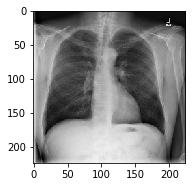

In [100]:
def get_score_and_cam_picture(image, densenet, feature_extractor):
    print(image.size)

dataset = XrayDataset()
image, label = dataset[10]
normallize = transforms.Normalize(IMAGENET_RGB_MEAN, IMAGENET_RGB_SD)
transform = transforms.Compose([
        transforms.Resize(WIDTH),
        transforms.ToTensor(),
        normallize
    ])

data = transform(image).unsqueeze(0)
data = Variable(data.cuda())

plt.subplot(121)
image = np.asarray(image)
image = cv2.resize(image, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
plt.imshow(image)

prediction = net(data)
conv_output = extractor(data)
class_weights = list(net.modules())[-2].weight
prediction = prediction.cpu().data.numpy().squeeze()
conv_output = conv_output.cpu().data.numpy().squeeze()
class_weights = class_weights.cpu().data.numpy().squeeze()
predicted_disease = np.argmax(prediction)
cam = np.zeros(dtype=np.float32, shape=conv_output.shape[1:])
for i, w in enumerate(class_weights[predicted_disease, :]):
    cam += w * conv_output[predicted_disease, :, :]

In [86]:
def plot_cam_results(crt_blended_image, crt_cam_image, crt_xray_image, map_caption):
    import matplotlib.pyplot as plt

    fig = plt.figure(figsize = (15,7))

    ax1 = fig.add_subplot(2, 3, 1)
    ax1.imshow(crt_xray_image, cmap = 'gray', interpolation = 'bicubic')
    ax1.set_title('Orig X Ray')
    plt.axis('off')

    ax2 = fig.add_subplot(2,3, 2)
    cam_plot = ax2.imshow(crt_cam_image, cmap=plt.get_cmap('OrRd'), interpolation = 'bicubic')
    plt.colorbar(cam_plot, ax=ax2)
    ax2.set_title('Activation Map')
    plt.axis('off')

    ax3 = fig.add_subplot(2,3, 3)
    blended_plot = ax3.imshow(crt_blended_image, interpolation = 'bicubic')
    plt.colorbar(cam_plot, ax=ax3)
    ax3.set_title(map_caption)
    plt.axis('off')
    plt.show()

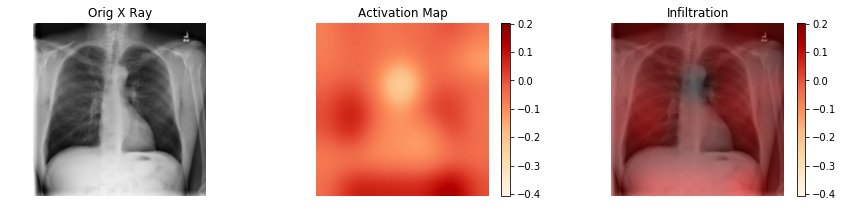

In [102]:
from azure_chestxray_cam import process_cam_image
blended_image = process_cam_image(cam, image)
plot_cam_results(blended_image, cam, image, CLASS_NAMES[predicted_disease])

In [45]:
# print(list(net.modules())[-5])
# print(list(net.modules())[-2].weight)
# relu = list(net.modules())[-2]
# print(relu)
# print(relu._tracing_name())
# dir(relu)

Parameter containing:
 1.1485e-15 -1.5641e-30 -3.4543e-26  ...   8.0709e-03  5.2040e-03 -1.1303e-02
-3.8946e-23  4.1429e-41 -5.7048e-41  ...  -2.4264e-02  5.1766e-02 -4.4727e-02
-2.8098e-16 -4.6195e-18  4.1032e-22  ...  -8.2214e-03  3.4137e-03  2.8350e-02
                ...                   ⋱                   ...                
-1.4152e-31  4.5839e-41 -6.3681e-41  ...  -1.4952e-02 -2.7632e-04  6.0646e-02
-2.8207e-19  4.8006e-41 -9.0286e-40  ...   9.3225e-03 -3.3108e-03  1.9259e-02
-7.4941e-39  1.4761e-41 -3.8886e-42  ...  -9.2289e-03 -5.1923e-02  2.4457e-02
[torch.cuda.FloatTensor of size 14x1024 (GPU 0)]



In [41]:
# for data, target in test_loader:
#     print(type(data), data.size())
#     print(type(target), data.size())
#     break

<class 'torch.FloatTensor'> torch.Size([64, 3, 224, 224])
<class 'torch.FloatTensor'> torch.Size([64, 3, 224, 224])


In [66]:
# print(densenet)